# Acordo Ortográfico 1990 — Full Analysis

Analyses two orthographic reform word-lists (pt-PT and pt-BR) to:  
1. Build a **unified CSV** with `old_pt_PT_ortho`, `old_pt_BR_ortho`, `unified_ortho` columns  
2. Classify every change by type (silent consonant removal, diacritic, hyphen, trema, capitalisation, …)  
3. Measure overlap, exclusivity and divergence between variants  
4. Produce extensive plots and a MLflow-tracked metrics report

## ⚙️ Configuration

In [1]:
import os

def _env(key, default=""):
    return os.environ.get(key, default)

def _flag(key, default=False):
    return os.environ.get(key, str(default)).lower() in ("1", "true", "yes")

# Input files  (override if running with your own paths)
PT_CSV          = _env("PT_CSV",  "./tugalex/data/acordo_ortografico_pt_PT.csv")
BR_CSV          = _env("BR_CSV",  "./tugalex/data/acordo_ortografico_pt_BR.csv")

# Output
OUTPUT_DIR      = _env("OUTPUT_DIR", "./ao_output")
UNIFIED_CSV     = os.path.join(OUTPUT_DIR, "unified_ortho.csv")

# MLflow
MLFLOW_TRACKING = _flag("MLFLOW_TRACKING", True)
MLFLOW_URI      = _env("MLFLOW_URI", "./mlruns")
MLFLOW_EXP      = _env("MLFLOW_EXP", "acordo_ortografico_analysis")

# HuggingFace upload
HF_TOKEN        = _env("HF_TOKEN") or None
HF_UPLOAD       = _flag("HF_UPLOAD", False)
HF_UPLOAD_REPO  = _env("HF_UPLOAD_REPO", "")

# Plot
FIG_DPI         = int(_env("FIG_DPI", "120"))
TOP_N           = int(_env("TOP_N", "30"))

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("PT_CSV  :", PT_CSV)
print("BR_CSV  :", BR_CSV)
print("OUTPUT  :", OUTPUT_DIR)

PT_CSV  : ./tugalex/data/acordo_ortografico_pt_PT.csv
BR_CSV  : ./tugalex/data/acordo_ortografico_pt_BR.csv
OUTPUT  : ./ao_output


## 📦 Dependencies

In [2]:
!pip install -q pandas matplotlib seaborn mlflow huggingface_hub scipy openpyxl --break-system-packages


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


## 📥 Load Raw Data

In [3]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

pt_raw = pd.read_csv(PT_CSV)
br_raw = pd.read_csv(BR_CSV)

# Normalise column names and strip whitespace
for df_ in (pt_raw, br_raw):
    df_.columns = df_.columns.str.strip()
    df_['old_form'] = df_['old_form'].astype(str).str.strip()
    df_['new_form'] = df_['new_form'].astype(str).str.strip()

print(f"pt_PT rows : {len(pt_raw):,}")
print(f"pt_BR rows : {len(br_raw):,}")
pt_raw.head(4)

pt_PT rows : 3,265
pt_BR rows : 2,058


,old_form,new_form
0,ab-reacção,ab-reação
1,ab-reactivo,ab-reativo
2,abaptista,abatista
3,abjecção,abjeção


## 🔀 Build Unified CSV

Logic:
- **`old_pt_PT_ortho`** — old form as it appeared in pt-PT (or NaN if word was only in pt-BR list)
- **`old_pt_BR_ortho`** — old form as it appeared in pt-BR (or NaN if word was only in pt-PT list)
- **`unified_ortho`** — the post-reform spelling (prefer pt-PT new_form when both agree; flag when they differ)

In [4]:
# For words with multiple accepted new forms (comma-separated), store the full string
# but also track the primary (first) form
def primary(s):
    """Return first comma-separated form."""
    return str(s).split(',')[0].strip()

pt = pt_raw.rename(columns={'old_form': 'old_pt_PT_ortho', 'new_form': 'new_pt_PT'})
br = br_raw.rename(columns={'old_form': 'old_pt_BR_ortho', 'new_form': 'new_pt_BR'})

# ── Full outer join on the unified new form key ──────────────────────────────
# Strategy: join on primary new form (they share the same post-reform spelling)
pt['_key'] = pt['new_pt_PT'].apply(primary)
br['_key'] = br['new_pt_BR'].apply(primary)

unified = pd.merge(pt, br, on='_key', how='outer')
unified['unified_ortho'] = unified['_key']
unified = unified.drop(columns=['_key'])

# Order columns nicely
unified = unified[['old_pt_PT_ortho', 'old_pt_BR_ortho', 'unified_ortho', 'new_pt_PT', 'new_pt_BR']]

# Flag divergences (when both sides present but new forms differ)
unified['new_forms_differ'] = (
    unified['new_pt_PT'].notna() &
    unified['new_pt_BR'].notna() &
    (unified['new_pt_PT'].apply(primary) != unified['new_pt_BR'].apply(primary))
)

# Origin column
def origin(row):
    has_pt = pd.notna(row['old_pt_PT_ortho']) and row['old_pt_PT_ortho'] != 'nan'
    has_br = pd.notna(row['old_pt_BR_ortho']) and row['old_pt_BR_ortho'] != 'nan'
    if has_pt and has_br:  return 'both'
    if has_pt:              return 'pt_PT_only'
    return                          'pt_BR_only'

unified['origin'] = unified.apply(origin, axis=1)

# Save
unified.to_csv(UNIFIED_CSV, index=False)
print(f"Unified CSV saved → {UNIFIED_CSV}")
print(f"Total entries : {len(unified):,}")
print(f"Origin breakdown:\n{unified['origin'].value_counts()}")
print(f"Divergent new forms: {unified['new_forms_differ'].sum()}")
unified.head(6)

Unified CSV saved → ./ao_output/unified_ortho.csv
Total entries : 3,908
Origin breakdown:
origin
pt_PT_only    1840
both          1435
pt_BR_only     633
Name: count, dtype: int64
Divergent new forms: 0


,old_pt_PT_ortho,old_pt_BR_ortho,unified_ortho,new_pt_PT,new_pt_BR,new_forms_differ,origin
0,Cenozóico,Cenozóico,Cenozoico,Cenozoico,Cenozoico,False,both
1,Eozóico,Eozóico,Eozoico,Eozoico,Eozoico,False,both
2,Equinóides,Equinóides,Equinoides,Equinoides,Equinoides,False,both
3,NaN,Eqüídeos,Equídeos,NaN,Equídeos,False,pt_BR_only
4,Fanerozóico,Fanerozóico,Fanerozoico,Fanerozoico,Fanerozoico,False,both
5,Mesozóico,Mesozóico,Mesozoico,Mesozoico,Mesozoico,False,both


## 🔬 Change Classification

In [5]:
CHANGE_TYPES = {
    'silent_consonant' : 'Silent consonant removal (ct/pt/cç/pç/cc/bb…)',
    'diacritic_removal': 'Diacritic/accent removal (â/ê on identical syllables, -óide→-oide…)',
    'hyphen_removal'   : 'Hyphen → fused word',
    'hyphen_to_space'  : 'Hyphen → space (open compound)',
    'trema_removal'    : 'Trema removal (ü→u, gü/qü)',
    'decapitalization' : 'Decapitalisation (month/weekday names)',
    'multiple_accepted': 'Multiple accepted spellings in new form',
    'other'            : 'Other / unclassified',
}

def classify_change(old, new):
    cats = set()
    old  = str(old).strip()
    new  = str(new).strip()

    if ',' in new:
        cats.add('multiple_accepted')
    new_p = new.split(',')[0].strip()  # primary form

    # Decapitalisation
    if old[0].isupper() and new_p[0].islower():
        cats.add('decapitalization')

    # Trema
    if re.search(r'[üïÜ]', old) or re.search(r'[gq]ü', old, re.I):
        cats.add('trema_removal')

    # Silent consonants — consonant cluster simplification
    # Patterns: ct/cç/pt/pç/cct/pp removal; bj->j; etc.
    silent_patterns = [
        (r'cc(?=[çcaeiouáéíóúâêîôûãõ])', r'c'),   # acção->ação
        (r'cç', 'ç'),
        (r'ct(?=[aeiouáéíóúâêîôûãõ])', 't'),       # abstracto->abstrato
        (r'pt(?=[aeiouáéíóúâêîôûãõ])', 't'),
        (r'pc(?=[aeiouáéíóúâêîôûãõ])', 'c'),
        (r'pb(?=[aeiouáéíóúâêîôûãõ])', 'b'),
        (r'gm(?=[aeiouáéíóúâêîôûãõ])', 'm'),
        (r'mn(?=[aeiouáéíóúâêîôûãõ])', 'n'),
        (r'bj', 'j'), (r'bt', 't'),
    ]
    for pat, _ in silent_patterns:
        if re.search(pat, old, re.I) and not re.search(pat, new_p, re.I):
            cats.add('silent_consonant')
            break
    # broader catch: consonant present in old but dropped
    # length of consonant clusters decreased
    old_clusters = re.findall(r'[bcdfghjklmnpqrstvwxyz]{2,}', old, re.I)
    new_clusters = re.findall(r'[bcdfghjklmnpqrstvwxyz]{2,}', new_p, re.I)
    old_max = max((len(c) for c in old_clusters), default=0)
    new_max = max((len(c) for c in new_clusters), default=0)
    if old_max > new_max and 'silent_consonant' not in cats and len(old) > len(new_p):
        cats.add('silent_consonant')

    # Diacritic removal
    # -óide/-óide/-éia/-éico style
    diac_patterns = [
        (r'óide', 'oide'), (r'éia', 'eia'), (r'éico', 'eico'),
        (r'êem', 'eem'),   (r'ôo',  'oo'),  (r'â(?=a)', 'a'),
        (r'ê(?=e)', 'e'),  (r'î',   'i'),
    ]
    for dpat, _ in diac_patterns:
        if re.search(dpat, old, re.I) and not re.search(dpat, new_p, re.I):
            cats.add('diacritic_removal')
            break
    # generic: accent count dropped
    acc_old = len(re.findall(r'[áéíóúâêîôûàèìòùãõ]', old))
    acc_new = len(re.findall(r'[áéíóúâêîôûàèìòùãõ]', new_p))
    if acc_new < acc_old and 'diacritic_removal' not in cats:
        cats.add('diacritic_removal')

    # Hyphen changes
    if '-' in old:
        if '-' not in new_p and ' ' in new_p:
            cats.add('hyphen_to_space')
        elif '-' not in new_p and ' ' not in new_p:
            cats.add('hyphen_removal')

    if not cats:
        cats.add('other')

    return sorted(cats)

# Test
test_cases = [
    ('ab-reacção', 'ab-reação'), ('abrotanóide', 'abrotanoide'),
    ('agüista', 'aguista'), ('cravagem-do-centeio', 'cravagem do centeio'),
    ('Abril', 'abril'), ('abstracto', 'abstrato'),
]
for old, new in test_cases:
    print(f"{old:35s} → {new:30s}  {classify_change(old, new)}")

ab-reacção                          → ab-reação                       ['silent_consonant']
abrotanóide                         → abrotanoide                     ['diacritic_removal']
agüista                             → aguista                         ['trema_removal']
cravagem-do-centeio                 → cravagem do centeio             ['hyphen_to_space']
Abril                               → abril                           ['decapitalization']
abstracto                           → abstrato                        ['silent_consonant']


In [6]:
# Apply classification to each source list
pt_raw['change_types'] = pt_raw.apply(
    lambda r: classify_change(r['old_form'], r['new_form']), axis=1
)
br_raw['change_types'] = br_raw.apply(
    lambda r: classify_change(r['old_form'], r['new_form']), axis=1
)

# Explode to one row per change type (for counting)
pt_exp = pt_raw.explode('change_types')
br_exp = br_raw.explode('change_types')

# Also add to unified
def unified_change(row):
    old = row['old_pt_PT_ortho'] if pd.notna(row['old_pt_PT_ortho']) and row['old_pt_PT_ortho'] != 'nan' \
          else row['old_pt_BR_ortho']
    new = row['new_pt_PT'] if pd.notna(row['new_pt_PT']) and row['new_pt_PT'] != 'nan' \
          else row['new_pt_BR']
    if pd.isna(old) or old == 'nan' or pd.isna(new) or new == 'nan':
        return ['other']
    return classify_change(old, new)

unified['change_types'] = unified.apply(unified_change, axis=1)
uni_exp = unified.explode('change_types')

print("PT change type distribution:")
print(pt_exp['change_types'].value_counts())
print("\nBR change type distribution:")
print(br_exp['change_types'].value_counts())

PT change type distribution:
change_types
silent_consonant     1606
diacritic_removal     560
hyphen_removal        526
hyphen_to_space       355
multiple_accepted     254
other                  49
decapitalization       20
Name: count, dtype: int64

BR change type distribution:
change_types
diacritic_removal    873
hyphen_removal       483
hyphen_to_space      355
trema_removal        321
other                 56
multiple_accepted     11
silent_consonant       8
Name: count, dtype: int64


## 📊 MLflow Setup

In [7]:
import mlflow

if MLFLOW_TRACKING:
    mlflow.set_tracking_uri(MLFLOW_URI)
    mlflow.set_experiment(MLFLOW_EXP)
    run = mlflow.start_run(run_name="ao_analysis")
    mlflow.log_params({
        'pt_rows'        : len(pt_raw),
        'br_rows'        : len(br_raw),
        'unified_rows'   : len(unified),
        'both_count'     : int((unified['origin'] == 'both').sum()),
        'pt_only_count'  : int((unified['origin'] == 'pt_PT_only').sum()),
        'br_only_count'  : int((unified['origin'] == 'pt_BR_only').sum()),
        'divergent_forms': int(unified['new_forms_differ'].sum()),
    })
    print("MLflow run:", run.info.run_id)
else:
    print("MLflow disabled.")

2026/02/19 02:44:48 INFO mlflow.tracking.fluent: Experiment with name 'acordo_ortografico_analysis' does not exist. Creating a new experiment.


MLflow run: 0d44c8cefae34d5ba220f48e5f7a2293


## 📈 Section 1 — Dataset Overview

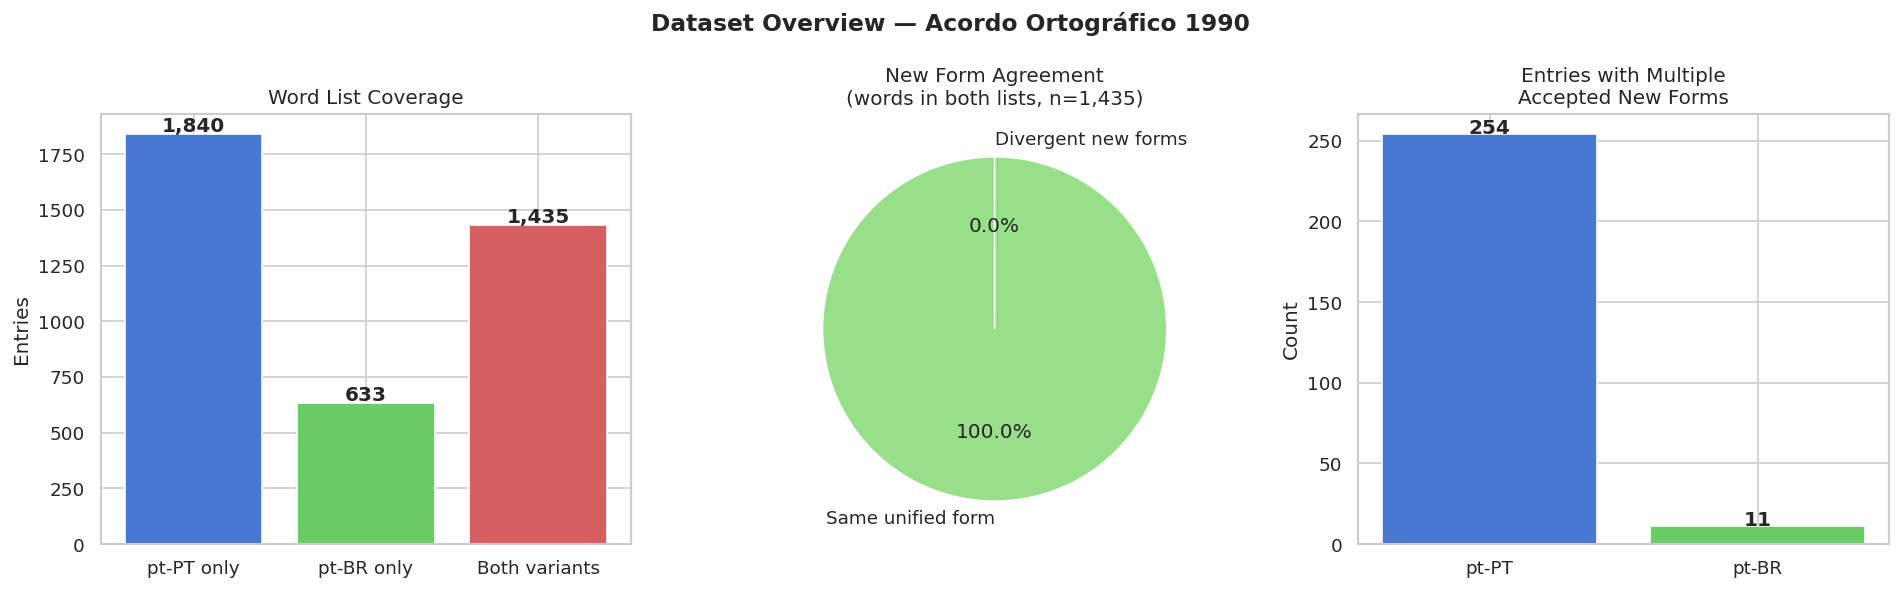

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = FIG_DPI
COLORS = {'pt_PT_only': '#4878CF', 'pt_BR_only': '#6ACC65', 'both': '#D65F5F'}

origin_counts = unified['origin'].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Dataset Overview — Acordo Ortográfico 1990', fontsize=14, fontweight='bold')

# 1. Venn-like bar chart
ax = axes[0]
bars = ax.bar(
    ['pt-PT only', 'pt-BR only', 'Both variants'],
    [origin_counts.get('pt_PT_only', 0),
     origin_counts.get('pt_BR_only', 0),
     origin_counts.get('both', 0)],
    color=['#4878CF', '#6ACC65', '#D65F5F'], edgecolor='white'
)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            f'{int(bar.get_height()):,}', ha='center', fontweight='bold')
ax.set_title('Word List Coverage')
ax.set_ylabel('Entries')

# 2. Divergent forms
ax = axes[1]
div = unified['new_forms_differ'].value_counts()
ax.pie(
    [div.get(False, 0), div.get(True, 0)],
    labels=['Same unified form', 'Divergent new forms'],
    autopct='%1.1f%%',
    colors=['#98DF8A', '#FF9896'],
    startangle=90
)
ax.set_title(f'New Form Agreement\n(words in both lists, n={origin_counts.get("both",0):,})')

# 3. Multiple accepted spellings
ax = axes[2]
pt_multi = pt_raw['new_form'].str.contains(',').sum()
br_multi = br_raw['new_form'].str.contains(',').sum()
ax.bar(['pt-PT', 'pt-BR'], [pt_multi, br_multi], color=['#4878CF','#6ACC65'], edgecolor='white')
ax.set_title('Entries with Multiple\nAccepted New Forms')
ax.set_ylabel('Count')
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            str(int(bar.get_height())), ha='center', fontweight='bold')

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, '01_overview.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 📊 Section 2 — Change Type Distribution

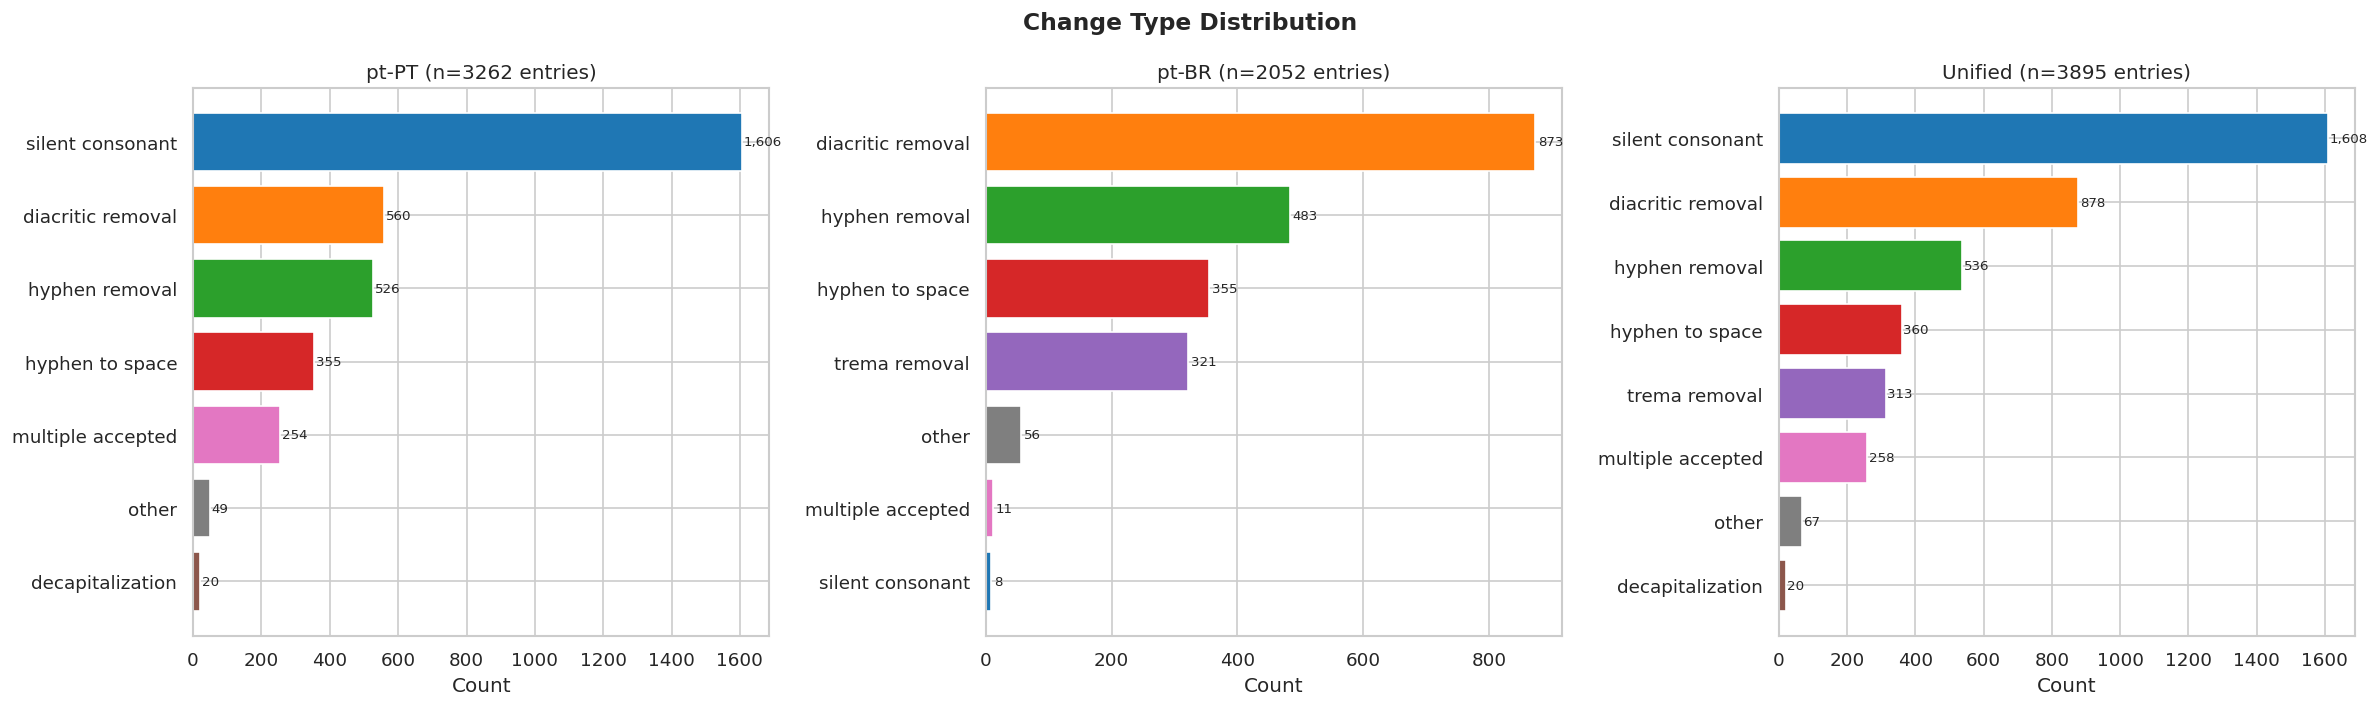

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Change Type Distribution', fontsize=14, fontweight='bold')

palette = sns.color_palette('tab10', len(CHANGE_TYPES))
ct_colors = {k: palette[i] for i, k in enumerate(CHANGE_TYPES)}

for ax, (exp_df, label) in zip(axes, [
    (pt_exp, 'pt-PT'),
    (br_exp, 'pt-BR'),
    (uni_exp, 'Unified'),
]):
    counts = exp_df['change_types'].value_counts()
    short_labels = [k.replace('_', ' ') for k in counts.index]
    colors = [ct_colors.get(k, 'grey') for k in counts.index]
    bars = ax.barh(short_labels[::-1], counts.values[::-1], color=colors[::-1], edgecolor='white')
    ax.set_title(f'{label} (n={len(exp_df.drop_duplicates(subset=exp_df.columns.difference(["change_types"]))):.0f} entries)')
    ax.set_xlabel('Count')
    for bar, val in zip(bars, counts.values[::-1]):
        ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
                f'{val:,}', va='center', fontsize=8)

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, '02_change_types.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

# Log metrics
if MLFLOW_TRACKING:
    for ct, cnt in uni_exp['change_types'].value_counts().items():
        mlflow.log_metric(f'change_{ct}', int(cnt))

## 🔵🟢 Section 3 — PT vs BR Change Type Comparison

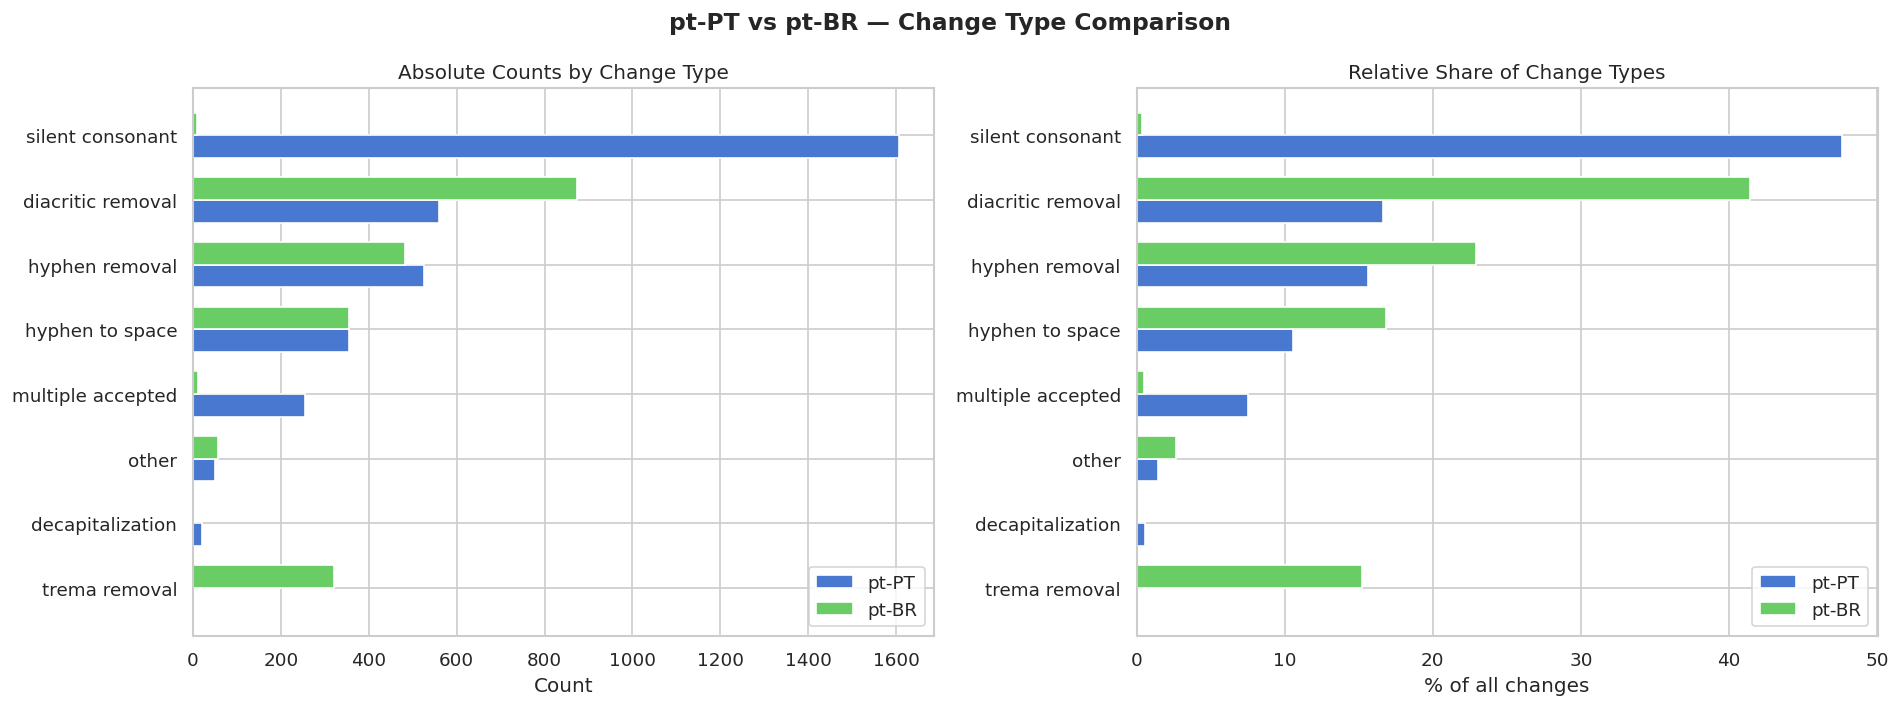

In [10]:
pt_ct = pt_exp['change_types'].value_counts().rename('pt_PT')
br_ct = br_exp['change_types'].value_counts().rename('pt_BR')
comp = pd.DataFrame({'pt_PT': pt_ct, 'pt_BR': br_ct}).fillna(0).astype(int)
comp = comp.sort_values('pt_PT', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('pt-PT vs pt-BR — Change Type Comparison', fontsize=14, fontweight='bold')

# Grouped bar
ax = axes[0]
x = np.arange(len(comp))
w = 0.35
ax.barh(x - w/2, comp['pt_PT'], w, label='pt-PT', color='#4878CF', edgecolor='white')
ax.barh(x + w/2, comp['pt_BR'], w, label='pt-BR', color='#6ACC65', edgecolor='white')
ax.set_yticks(x)
ax.set_yticklabels([k.replace('_',' ') for k in comp.index])
ax.set_xlabel('Count')
ax.set_title('Absolute Counts by Change Type')
ax.legend()

# Relative % comparison
ax = axes[1]
pct = comp.copy()
pct['pt_PT'] = pct['pt_PT'] / pct['pt_PT'].sum() * 100
pct['pt_BR'] = pct['pt_BR'] / pct['pt_BR'].sum() * 100
ax.barh(x - w/2, pct['pt_PT'], w, label='pt-PT', color='#4878CF', edgecolor='white')
ax.barh(x + w/2, pct['pt_BR'], w, label='pt-BR', color='#6ACC65', edgecolor='white')
ax.set_yticks(x)
ax.set_yticklabels([k.replace('_',' ') for k in comp.index])
ax.set_xlabel('% of all changes')
ax.set_title('Relative Share of Change Types')
ax.legend()

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, '03_pt_vs_br_changes.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## ✂️ Section 4 — Word Length Change Analysis

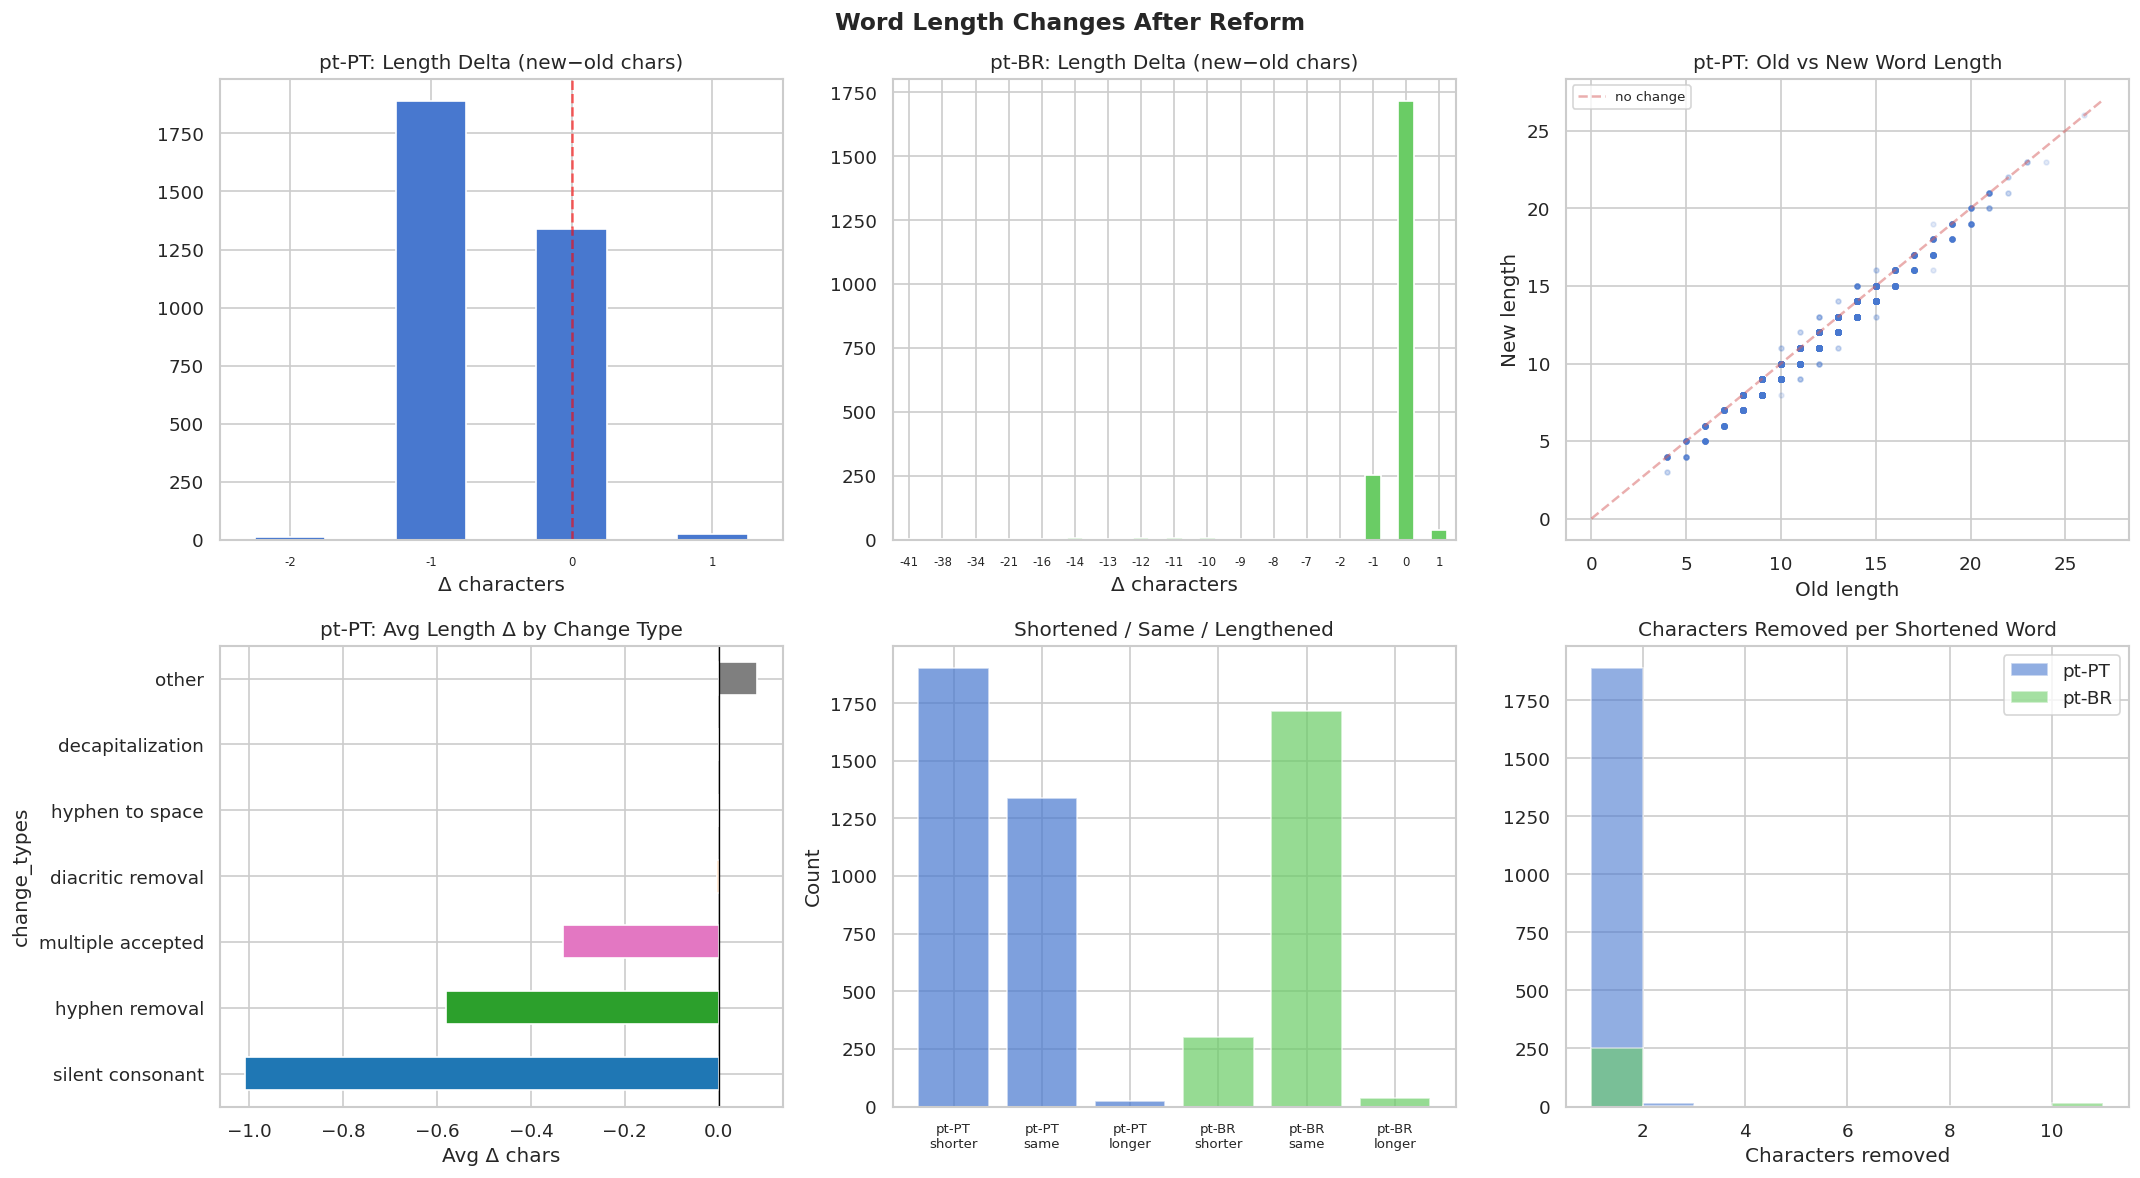

In [11]:
def add_length_metrics(df_):
    df_ = df_.copy()
    df_['old_len']   = df_['old_form'].str.len()
    df_['new_len']   = df_['new_form'].apply(lambda x: len(str(x).split(',')[0].strip()))
    df_['len_delta'] = df_['new_len'] - df_['old_len']
    return df_

pt_m = add_length_metrics(pt_raw)
br_m = add_length_metrics(br_raw)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Word Length Changes After Reform', fontsize=14, fontweight='bold')

# 1. Length delta distribution — pt
ax = axes[0,0]
pt_m['len_delta'].value_counts().sort_index().plot(kind='bar', ax=ax, color='#4878CF', edgecolor='white')
ax.axvline(ax.get_xticks()[list(pt_m['len_delta'].value_counts().sort_index().index).index(0)],
            color='red', linestyle='--', alpha=0.6, label='no change')
ax.set_title('pt-PT: Length Delta (new−old chars)')
ax.set_xlabel('Δ characters')
ax.tick_params(axis='x', rotation=0, labelsize=7)

# 2. Length delta distribution — br
ax = axes[0,1]
br_m['len_delta'].value_counts().sort_index().plot(kind='bar', ax=ax, color='#6ACC65', edgecolor='white')
ax.set_title('pt-BR: Length Delta (new−old chars)')
ax.set_xlabel('Δ characters')
ax.tick_params(axis='x', rotation=0, labelsize=7)

# 3. Old vs new length scatter — pt
ax = axes[0,2]
ax.scatter(pt_m['old_len'], pt_m['new_len'], alpha=0.15, s=8, color='#4878CF')
lim = max(pt_m['old_len'].max(), pt_m['new_len'].max()) + 1
ax.plot([0, lim], [0, lim], 'r--', alpha=0.5, label='no change')
ax.set_title('pt-PT: Old vs New Word Length')
ax.set_xlabel('Old length'); ax.set_ylabel('New length')
ax.legend(fontsize=8)

# 4. Length delta by change type — pt
ax = axes[1,0]
ct_delta = pt_m.explode('change_types').groupby('change_types')['len_delta'].mean().sort_values()
ct_delta.plot(kind='barh', ax=ax, color=[ct_colors.get(k,'grey') for k in ct_delta.index])
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title('pt-PT: Avg Length Δ by Change Type')
ax.set_xlabel('Avg Δ chars')
ax.set_yticklabels([k.replace('_',' ') for k in ct_delta.index])

# 5. Shortened vs lengthened vs same
ax = axes[1,1]
for df_, label, color in [(pt_m,'pt-PT','#4878CF'), (br_m,'pt-BR','#6ACC65')]:
    shorter  = (df_['len_delta'] < 0).sum()
    same     = (df_['len_delta'] == 0).sum()
    longer   = (df_['len_delta'] > 0).sum()
    ax.bar([f'{label}\nshorter', f'{label}\nsame', f'{label}\nlonger'],
           [shorter, same, longer], color=[color]*3, edgecolor='white', alpha=0.7)
ax.set_title('Shortened / Same / Lengthened')
ax.set_ylabel('Count')
ax.tick_params(axis='x', labelsize=8)

# 6. Chars saved histogram
ax = axes[1,2]
chars_saved_pt = -pt_m.loc[pt_m['len_delta'] < 0, 'len_delta']
chars_saved_br = -br_m.loc[br_m['len_delta'] < 0, 'len_delta']
ax.hist(chars_saved_pt, bins=range(1, 12), alpha=0.6, color='#4878CF', label='pt-PT', edgecolor='white')
ax.hist(chars_saved_br, bins=range(1, 12), alpha=0.6, color='#6ACC65', label='pt-BR', edgecolor='white')
ax.set_title('Characters Removed per Shortened Word')
ax.set_xlabel('Characters removed')
ax.legend()

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, '04_word_length_changes.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
if MLFLOW_TRACKING:
    mlflow.log_artifact(p)
    mlflow.log_metrics({
        'pt_avg_len_delta'  : float(pt_m['len_delta'].mean()),
        'br_avg_len_delta'  : float(br_m['len_delta'].mean()),
        'pt_pct_shortened'  : float((pt_m['len_delta']<0).mean()*100),
        'br_pct_shortened'  : float((br_m['len_delta']<0).mean()*100),
        'pt_total_chars_saved': int(-pt_m.loc[pt_m['len_delta']<0,'len_delta'].sum()),
        'br_total_chars_saved': int(-br_m.loc[br_m['len_delta']<0,'len_delta'].sum()),
    })

## 🔗 Section 5 — Hyphen Changes Deep Dive

pt-PT hyphenated old forms: 974
hyphen_fate
no_hyphen    2291
fused         526
to_space      355
kept           93
Name: count, dtype: int64

pt-BR hyphenated old forms: 876
hyphen_fate
no_hyphen    1182
fused         483
to_space      355
kept           38
Name: count, dtype: int64


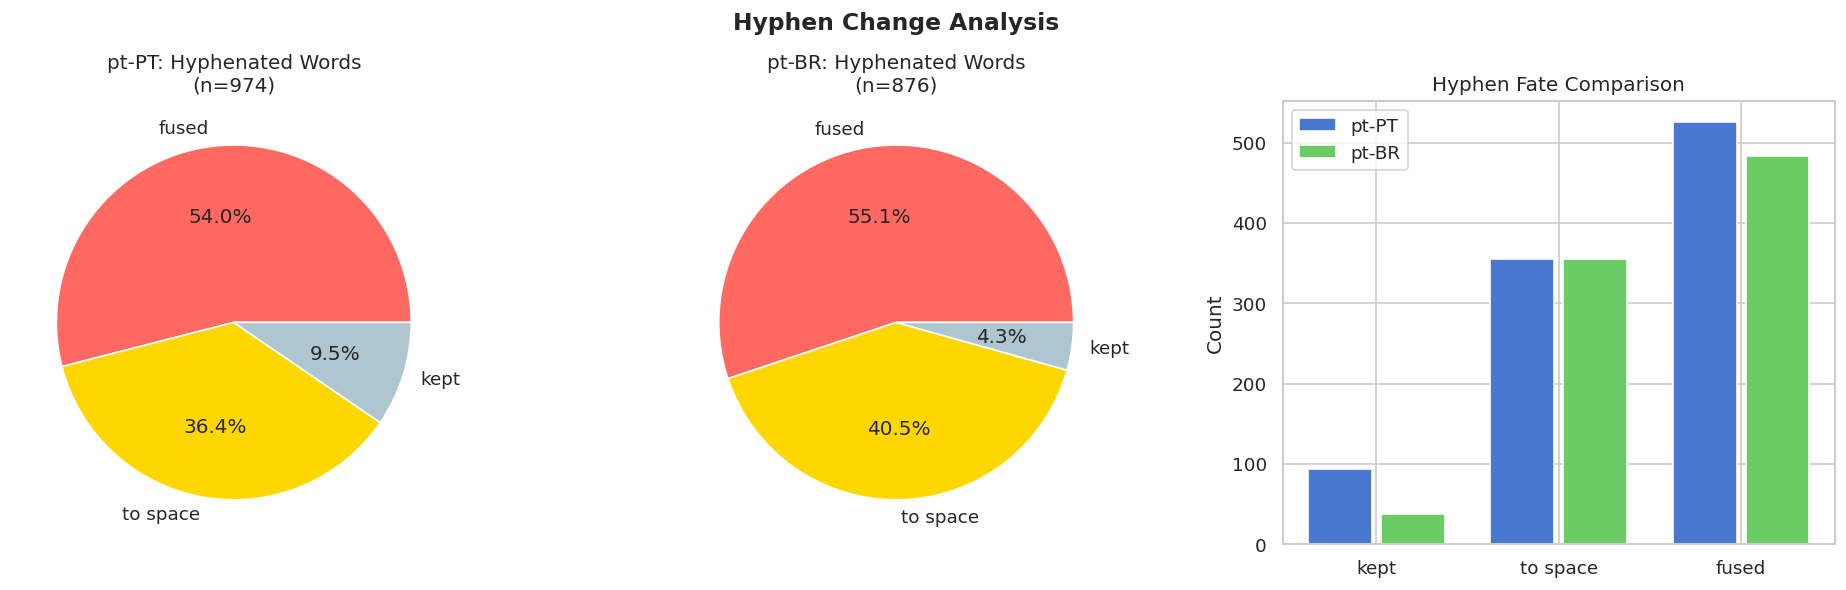

In [12]:
# Extract all hyphen-related entries
def hyphen_fate(old, new):
    new_p = str(new).split(',')[0].strip()
    if '-' not in str(old): return 'no_hyphen'
    if '-' in new_p: return 'kept'
    if ' ' in new_p: return 'to_space'
    return 'fused'

pt_m['hyphen_fate'] = pt_m.apply(lambda r: hyphen_fate(r['old_form'], r['new_form']), axis=1)
br_m['hyphen_fate'] = br_m.apply(lambda r: hyphen_fate(r['old_form'], r['new_form']), axis=1)

pt_hyph = pt_m[pt_m['hyphen_fate'] != 'no_hyphen']
br_hyph = br_m[br_m['hyphen_fate'] != 'no_hyphen']

print(f"pt-PT hyphenated old forms: {len(pt_hyph):,}")
print(pt_m['hyphen_fate'].value_counts())
print(f"\npt-BR hyphenated old forms: {len(br_hyph):,}")
print(br_m['hyphen_fate'].value_counts())

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Hyphen Change Analysis', fontsize=14, fontweight='bold')

hyphen_palette = {'kept':'#AEC6CF','to_space':'#FFD700','fused':'#FF6961'}

# pt-PT hyphen fate
ax = axes[0]
fates = pt_m[pt_m['hyphen_fate']!='no_hyphen']['hyphen_fate'].value_counts()
ax.pie(fates, labels=[f.replace('_',' ') for f in fates.index],
       autopct='%1.1f%%', colors=[hyphen_palette.get(k,'grey') for k in fates.index])
ax.set_title(f'pt-PT: Hyphenated Words\n(n={len(pt_hyph):,})')

# pt-BR hyphen fate
ax = axes[1]
fates_br = br_m[br_m['hyphen_fate']!='no_hyphen']['hyphen_fate'].value_counts()
ax.pie(fates_br, labels=[f.replace('_',' ') for f in fates_br.index],
       autopct='%1.1f%%', colors=[hyphen_palette.get(k,'grey') for k in fates_br.index])
ax.set_title(f'pt-BR: Hyphenated Words\n(n={len(br_hyph):,})')

# Grouped comparison
ax = axes[2]
all_fates = ['kept','to_space','fused']
pt_vals = [pt_m[pt_m['hyphen_fate']!='no_hyphen']['hyphen_fate'].value_counts().get(f,0) for f in all_fates]
br_vals = [br_m[br_m['hyphen_fate']!='no_hyphen']['hyphen_fate'].value_counts().get(f,0) for f in all_fates]
x_ = np.arange(len(all_fates))
ax.bar(x_-0.2, pt_vals, 0.35, label='pt-PT', color='#4878CF', edgecolor='white')
ax.bar(x_+0.2, br_vals, 0.35, label='pt-BR', color='#6ACC65', edgecolor='white')
ax.set_xticks(x_)
ax.set_xticklabels([f.replace('_',' ') for f in all_fates])
ax.set_title('Hyphen Fate Comparison')
ax.set_ylabel('Count'); ax.legend()

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, '05_hyphen_changes.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 🔤 Section 6 — Character-Level Changes

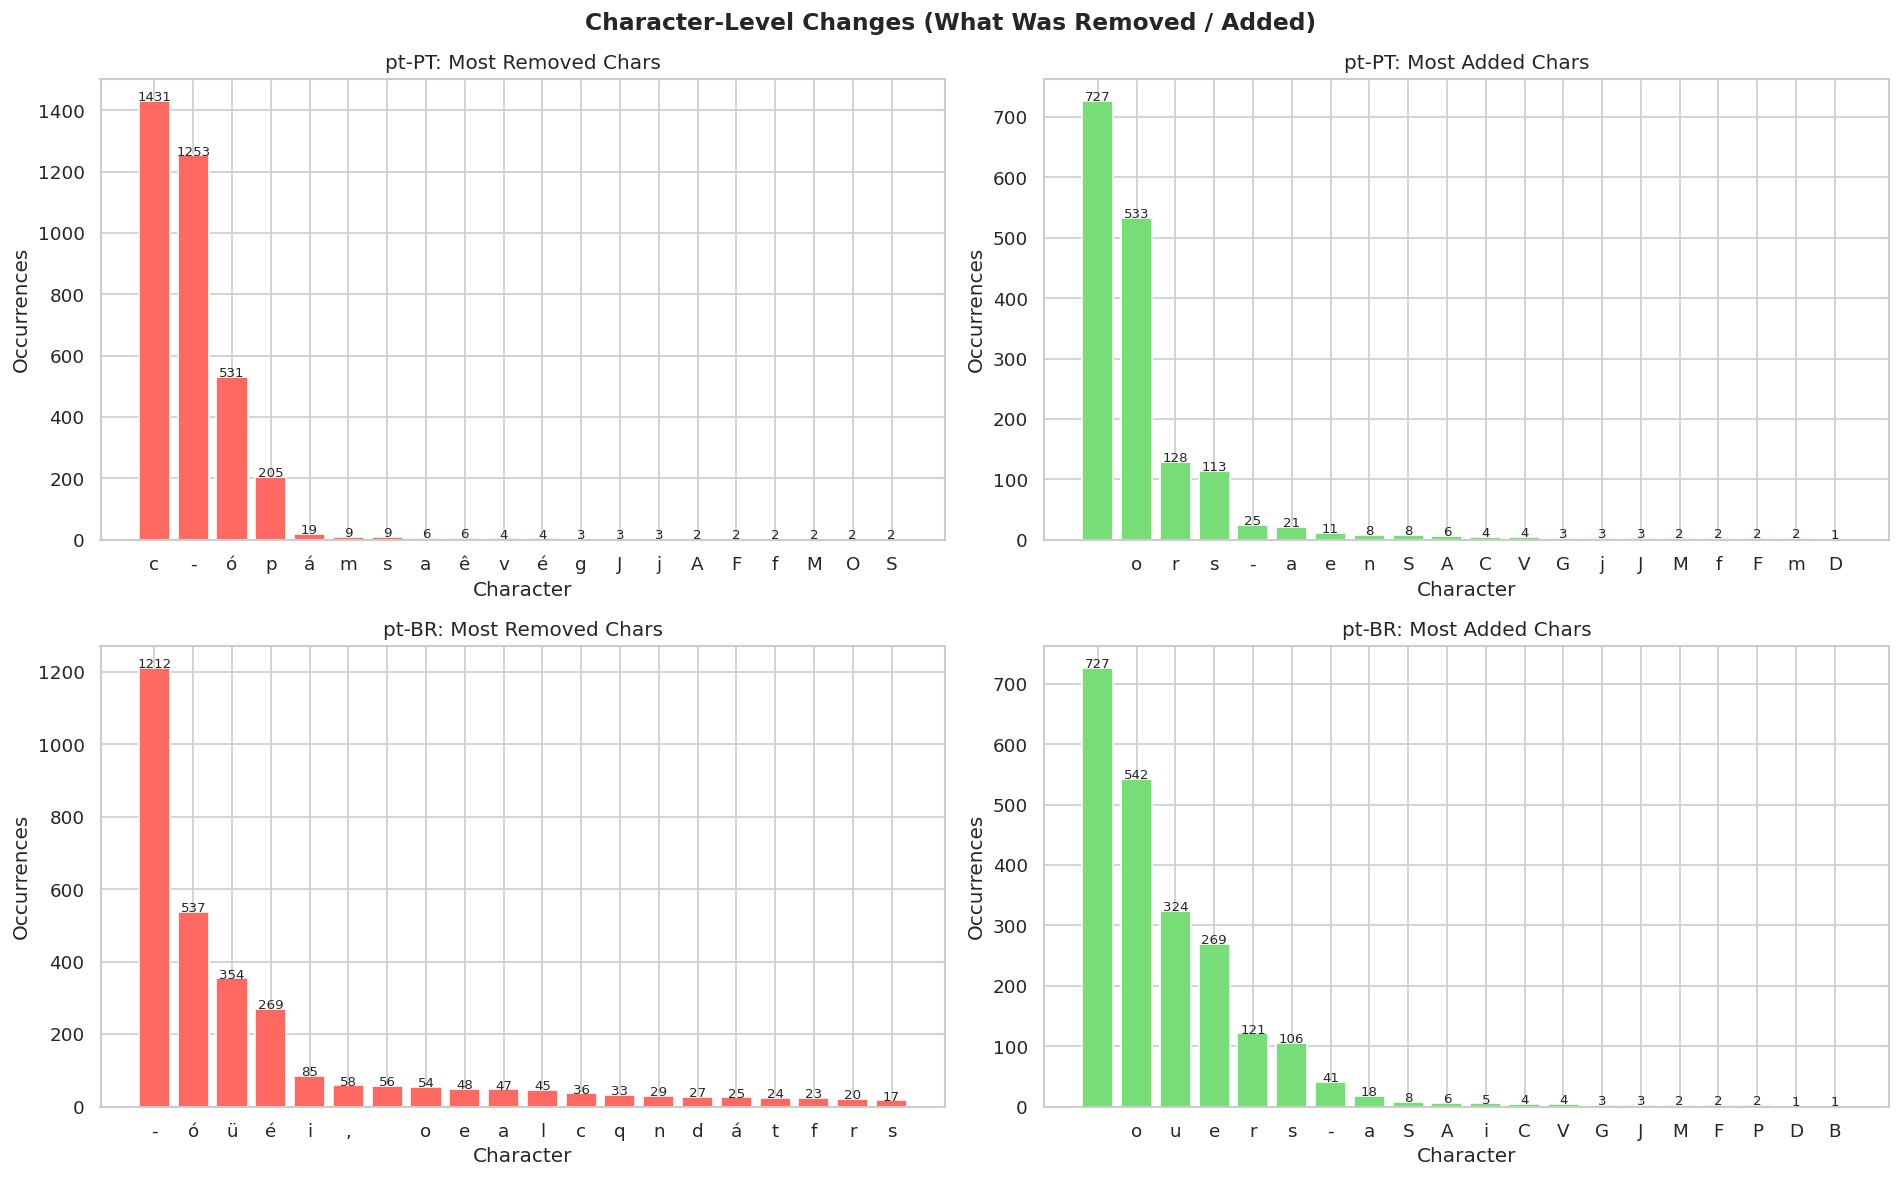

In [13]:
from collections import Counter
import difflib

def char_level_diff(old, new_s):
    """Return dicts of chars added and removed."""
    new_p = str(new_s).split(',')[0].strip()
    removed, added = [], []
    matcher = difflib.SequenceMatcher(None, str(old), new_p)
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'delete':  removed.extend(list(old[i1:i2]))
        elif tag == 'insert': added.extend(list(new_p[j1:j2]))
        elif tag == 'replace':
            removed.extend(list(old[i1:i2]))
            added.extend(list(new_p[j1:j2]))
    return removed, added

# Aggregate across pt-PT
all_removed_pt, all_added_pt = Counter(), Counter()
for _, row in pt_raw.iterrows():
    rem, add = char_level_diff(row['old_form'], row['new_form'])
    all_removed_pt.update(rem)
    all_added_pt.update(add)

all_removed_br, all_added_br = Counter(), Counter()
for _, row in br_raw.iterrows():
    rem, add = char_level_diff(row['old_form'], row['new_form'])
    all_removed_br.update(rem)
    all_added_br.update(add)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Character-Level Changes (What Was Removed / Added)', fontsize=14, fontweight='bold')

for ax, data, title in [
    (axes[0,0], all_removed_pt.most_common(20), 'pt-PT: Most Removed Chars'),
    (axes[0,1], all_added_pt.most_common(20),   'pt-PT: Most Added Chars'),
    (axes[1,0], all_removed_br.most_common(20), 'pt-BR: Most Removed Chars'),
    (axes[1,1], all_added_br.most_common(20),   'pt-BR: Most Added Chars'),
]:
    if not data: continue
    chars, counts = zip(*data)
    color = '#FF6961' if 'Removed' in title else '#77DD77'
    bars = ax.bar(chars, counts, color=color, edgecolor='white')
    ax.set_title(title)
    ax.set_ylabel('Occurrences')
    ax.set_xlabel('Character')
    for bar in bars:
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5,
                str(int(bar.get_height())), ha='center', fontsize=8)

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, '06_char_changes.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 🔠 Section 7 — Common Substring Patterns Removed

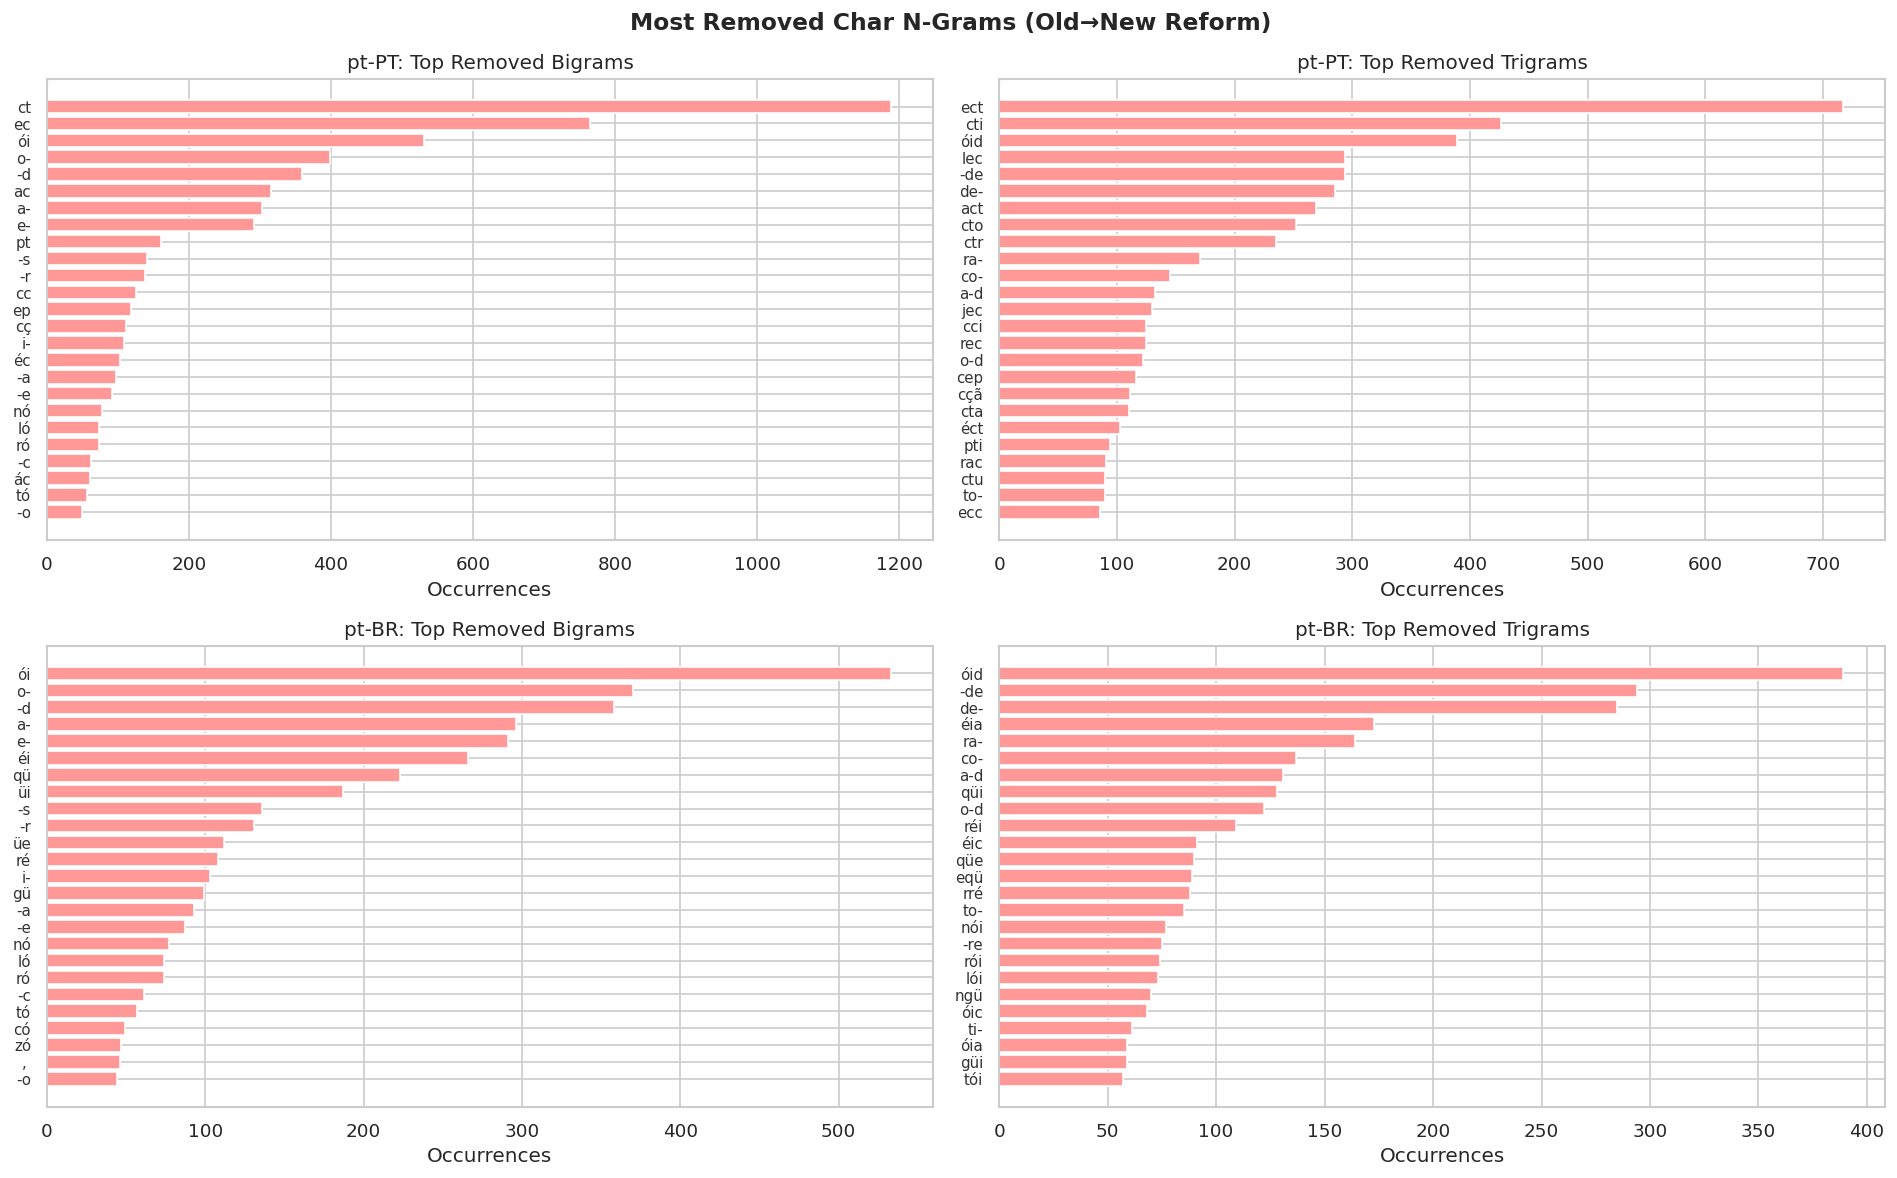

In [14]:
# What substrings (bigrams, trigrams) are most often removed from old forms?
def ngram_diff(old, new_s, n=2):
    new_p = str(new_s).split(',')[0].strip()
    old_ng  = [old[i:i+n]  for i in range(len(old)-n+1)]
    new_ng  = [new_p[i:i+n] for i in range(len(new_p)-n+1)]
    removed = set(old_ng) - set(new_ng)
    return list(removed)

pt_bigrams_removed = Counter()
pt_trigrams_removed = Counter()
for _, row in pt_raw.iterrows():
    pt_bigrams_removed.update(ngram_diff(row['old_form'], row['new_form'], 2))
    pt_trigrams_removed.update(ngram_diff(row['old_form'], row['new_form'], 3))

br_bigrams_removed = Counter()
br_trigrams_removed = Counter()
for _, row in br_raw.iterrows():
    br_bigrams_removed.update(ngram_diff(row['old_form'], row['new_form'], 2))
    br_trigrams_removed.update(ngram_diff(row['old_form'], row['new_form'], 3))

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Most Removed Char N-Grams (Old→New Reform)', fontsize=14, fontweight='bold')

for ax, data, title in [
    (axes[0,0], pt_bigrams_removed.most_common(25), 'pt-PT: Top Removed Bigrams'),
    (axes[0,1], pt_trigrams_removed.most_common(25),'pt-PT: Top Removed Trigrams'),
    (axes[1,0], br_bigrams_removed.most_common(25), 'pt-BR: Top Removed Bigrams'),
    (axes[1,1], br_trigrams_removed.most_common(25),'pt-BR: Top Removed Trigrams'),
]:
    if not data: continue
    ng, cnts = zip(*data)
    ax.barh(ng[::-1], cnts[::-1], color='#FF9896', edgecolor='white')
    ax.set_title(title)
    ax.set_xlabel('Occurrences')
    ax.tick_params(axis='y', labelsize=9, labelcolor='#333')

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, '07_ngram_removed.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## ⚠️ Section 8 — Divergences Between pt-PT and pt-BR

In [15]:
divergent = unified[unified['new_forms_differ']].copy()
print(f"Total divergent entries: {len(divergent)}")
print("\n".join(f"{row['old_pt_PT_ortho']:35s}  PT→{row['new_pt_PT']:35s}  BR→{row['new_pt_BR']}"
               for _, row in divergent.iterrows()))

Total divergent entries: 0




Shared entries: 1,435
Average Levenshtein distance (new PT vs new BR): 0.0000
Entries with lev_dist > 0: 0 (0.0%)


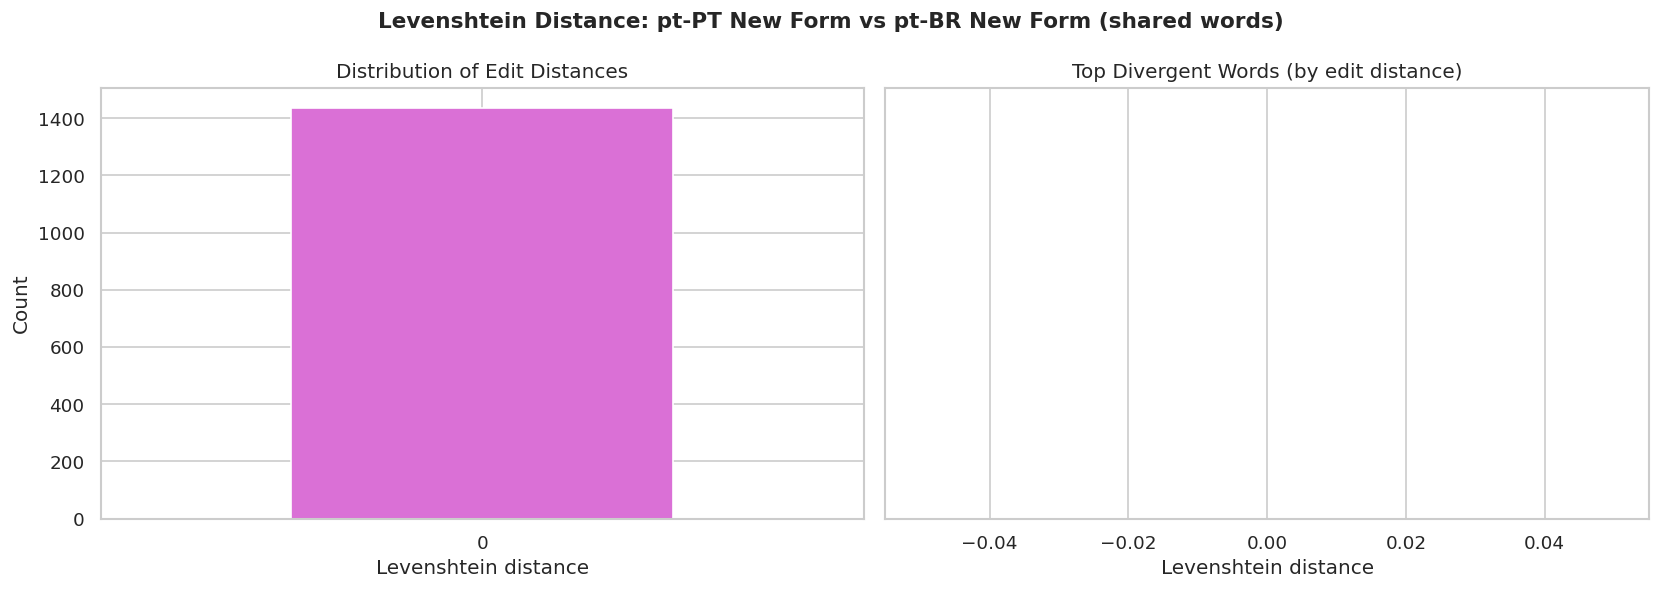

In [16]:
# Levenshtein distance between all PT and BR new forms (for shared words)
def levenshtein(s1, s2):
    s1, s2 = str(s1).split(',')[0].strip(), str(s2).split(',')[0].strip()
    if len(s1) < len(s2): s1, s2 = s2, s1
    if not s2: return len(s1)
    prev = list(range(len(s2)+1))
    for i, c1 in enumerate(s1):
        curr = [i+1]
        for j, c2 in enumerate(s2):
            curr.append(min(prev[j+1]+1, curr[j]+1, prev[j]+(c1!=c2)))
        prev = curr
    return prev[-1]

shared = unified[(unified['origin']=='both') &
                  unified['new_pt_PT'].notna() & unified['new_pt_BR'].notna()].copy()
shared['lev_dist'] = shared.apply(
    lambda r: levenshtein(r['new_pt_PT'], r['new_pt_BR']), axis=1
)

print(f"\nShared entries: {len(shared):,}")
print(f"Average Levenshtein distance (new PT vs new BR): {shared['lev_dist'].mean():.4f}")
print(f"Entries with lev_dist > 0: {(shared['lev_dist']>0).sum()} ({(shared['lev_dist']>0).mean()*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Levenshtein Distance: pt-PT New Form vs pt-BR New Form (shared words)',
             fontsize=13, fontweight='bold')

ax = axes[0]
shared['lev_dist'].value_counts().sort_index().plot(kind='bar', ax=ax, color='orchid', edgecolor='white')
ax.set_title('Distribution of Edit Distances')
ax.set_xlabel('Levenshtein distance')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)

ax = axes[1]
top_lev = shared[shared['lev_dist']>0].sort_values('lev_dist', ascending=False).head(15)
y_labels = [f"{r['old_pt_PT_ortho'][:20]}" for _, r in top_lev.iterrows()]
ax.barh(range(len(top_lev)), top_lev['lev_dist'].values, color='orchid', edgecolor='white')
ax.set_yticks(range(len(top_lev)))
ax.set_yticklabels(y_labels, fontsize=8)
ax.set_title('Top Divergent Words (by edit distance)')
ax.set_xlabel('Levenshtein distance')
ax.invert_yaxis()

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, '08_pt_br_divergence.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
if MLFLOW_TRACKING:
    mlflow.log_artifact(p)
    mlflow.log_metric('avg_lev_dist_pt_vs_br', float(shared['lev_dist'].mean()))

## 🌐 Section 9 — Exclusive Words: What Each Variant Changed Alone

pt-PT exclusive entries : 1,840
pt-BR exclusive entries : 633


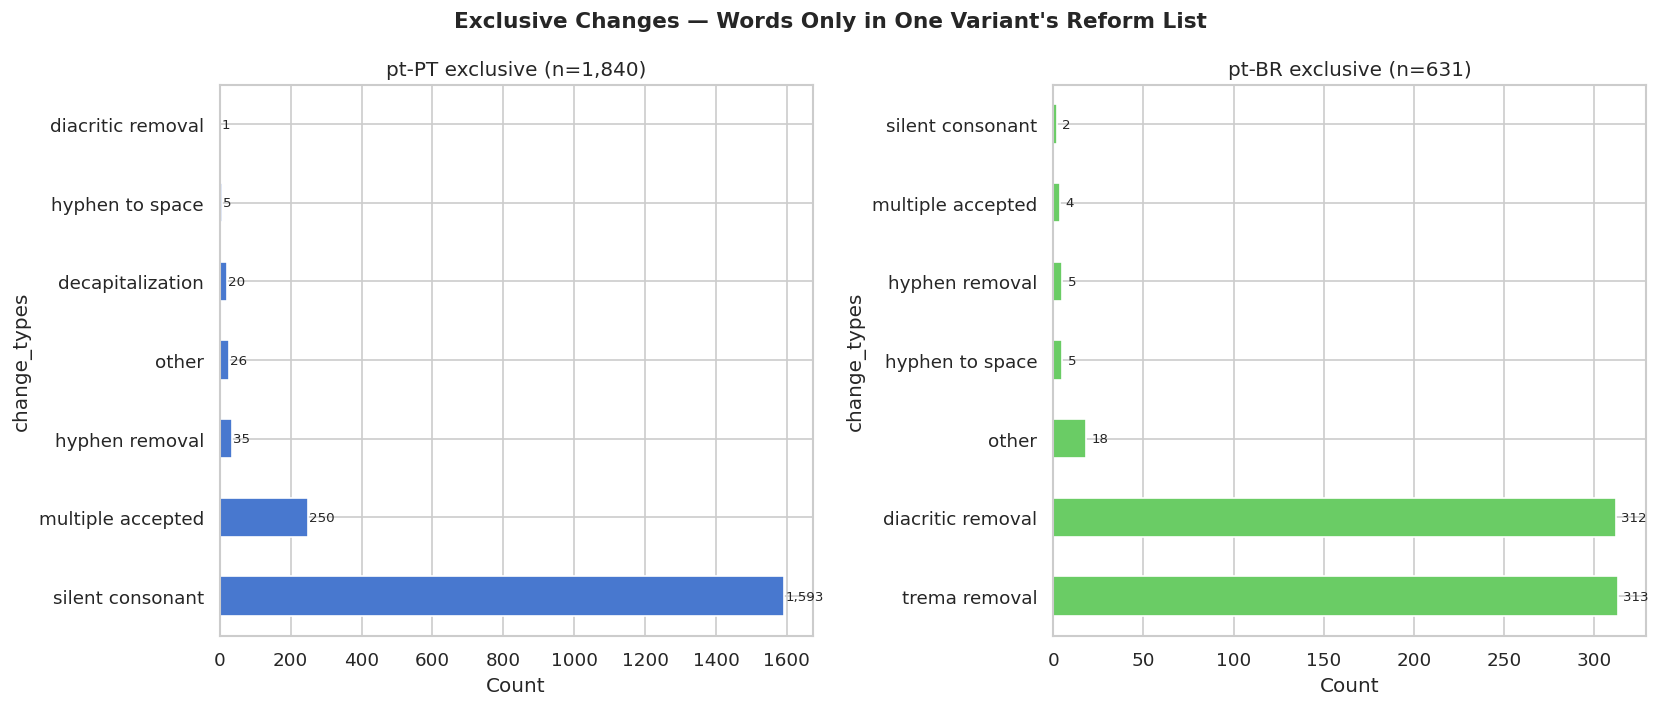

In [17]:
pt_only = unified[unified['origin']=='pt_PT_only'].copy()
br_only = unified[unified['origin']=='pt_BR_only'].copy()

print(f"pt-PT exclusive entries : {len(pt_only):,}")
print(f"pt-BR exclusive entries : {len(br_only):,}")

# Classify exclusive entries
pt_only_exp = pt_only.explode('change_types')
br_only_exp = br_only.explode('change_types')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Exclusive Changes — Words Only in One Variant\'s Reform List', fontsize=13, fontweight='bold')

for ax, exp_df, label, color in [
    (axes[0], pt_only_exp, 'pt-PT exclusive', '#4878CF'),
    (axes[1], br_only_exp, 'pt-BR exclusive', '#6ACC65'),
]:
    counts = exp_df['change_types'].value_counts()
    counts.plot(kind='barh', ax=ax, color=color, edgecolor='white')
    ax.set_title(f'{label} (n={len(exp_df.drop_duplicates(subset=["unified_ortho"])):,})')
    ax.set_xlabel('Count')
    ax.set_yticklabels([k.replace('_',' ') for k in counts.index])
    for bar, val in zip(ax.patches, counts.values):
        ax.text(bar.get_width()+3, bar.get_y()+bar.get_height()/2,
                f'{val:,}', va='center', fontsize=8)

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, '09_exclusive_changes.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 📊 Section 10 — Phoneme-Pattern Impact (Silent Consonant Deep Dive)

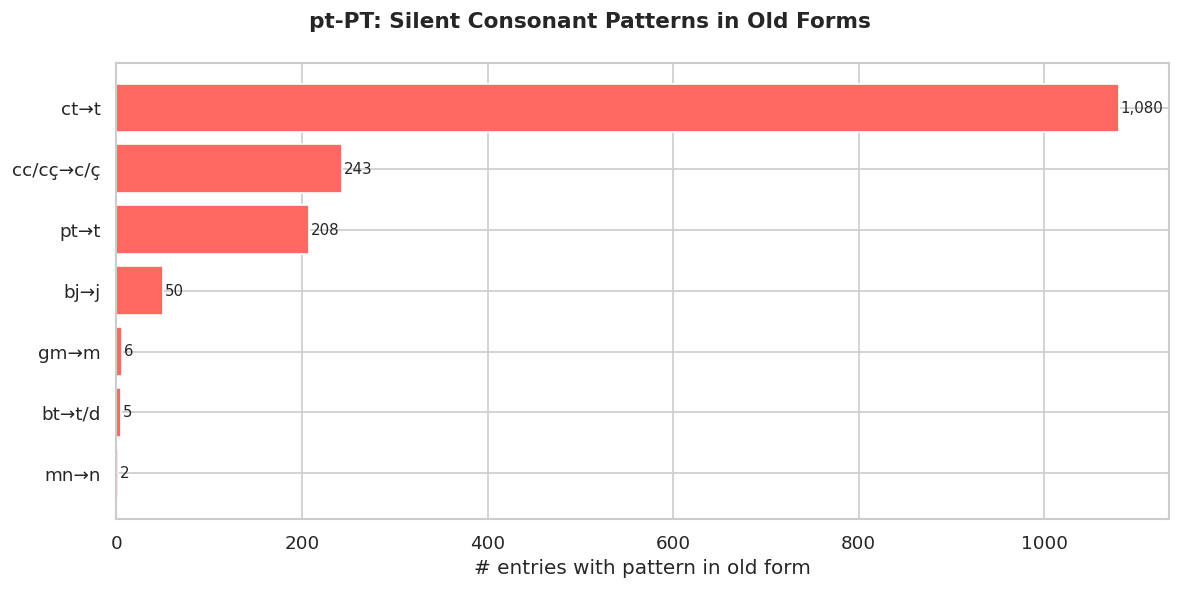

In [18]:
# What specific consonant sequences were silenced in pt-PT?
SILENT_PATTERNS = {
    'cc/cç→c/ç': (r'cc[çaeiouáéíóúâêîôûãõ]|cç', r'c[çaeiouáéíóúâêîôûãõ]|ç'),
    'ct→t':       (r'ct[aeiouáéíóúâêîôûãõ]',     r't[aeiouáéíóúâêîôûãõ]'),
    'pt→t':       (r'pt[aeiouáéíóúâêîôûãõ]',     r't[aeiouáéíóúâêîôûãõ]'),
    'gm→m':       (r'gm',                          r'm(?<![g])'),
    'mn→n':       (r'mn',                          r'n(?<![m])'),
    'bj→j':       (r'bj',                          r'j(?<![b])'),
    'bt→t/d':     (r'bt',                          r'[td](?<![b])'),
}

pattern_counts = {}
for label, (old_pat, _) in SILENT_PATTERNS.items():
    n = pt_raw[pt_raw['old_form'].str.contains(old_pat, case=False, na=False, regex=True)].shape[0]
    pattern_counts[label] = n

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('pt-PT: Silent Consonant Patterns in Old Forms', fontsize=13, fontweight='bold')
items = sorted(pattern_counts.items(), key=lambda x: -x[1])
labels_, vals_ = zip(*items)
bars = ax.barh(labels_[::-1], vals_[::-1], color='#FF6961', edgecolor='white')
for bar, val in zip(bars, vals_[::-1]):
    ax.text(bar.get_width()+2, bar.get_y()+bar.get_height()/2,
            f'{val:,}', va='center', fontsize=9)
ax.set_xlabel('# entries with pattern in old form')

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, '10_silent_consonants.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 📊 Section 11 — Dashboard Overview

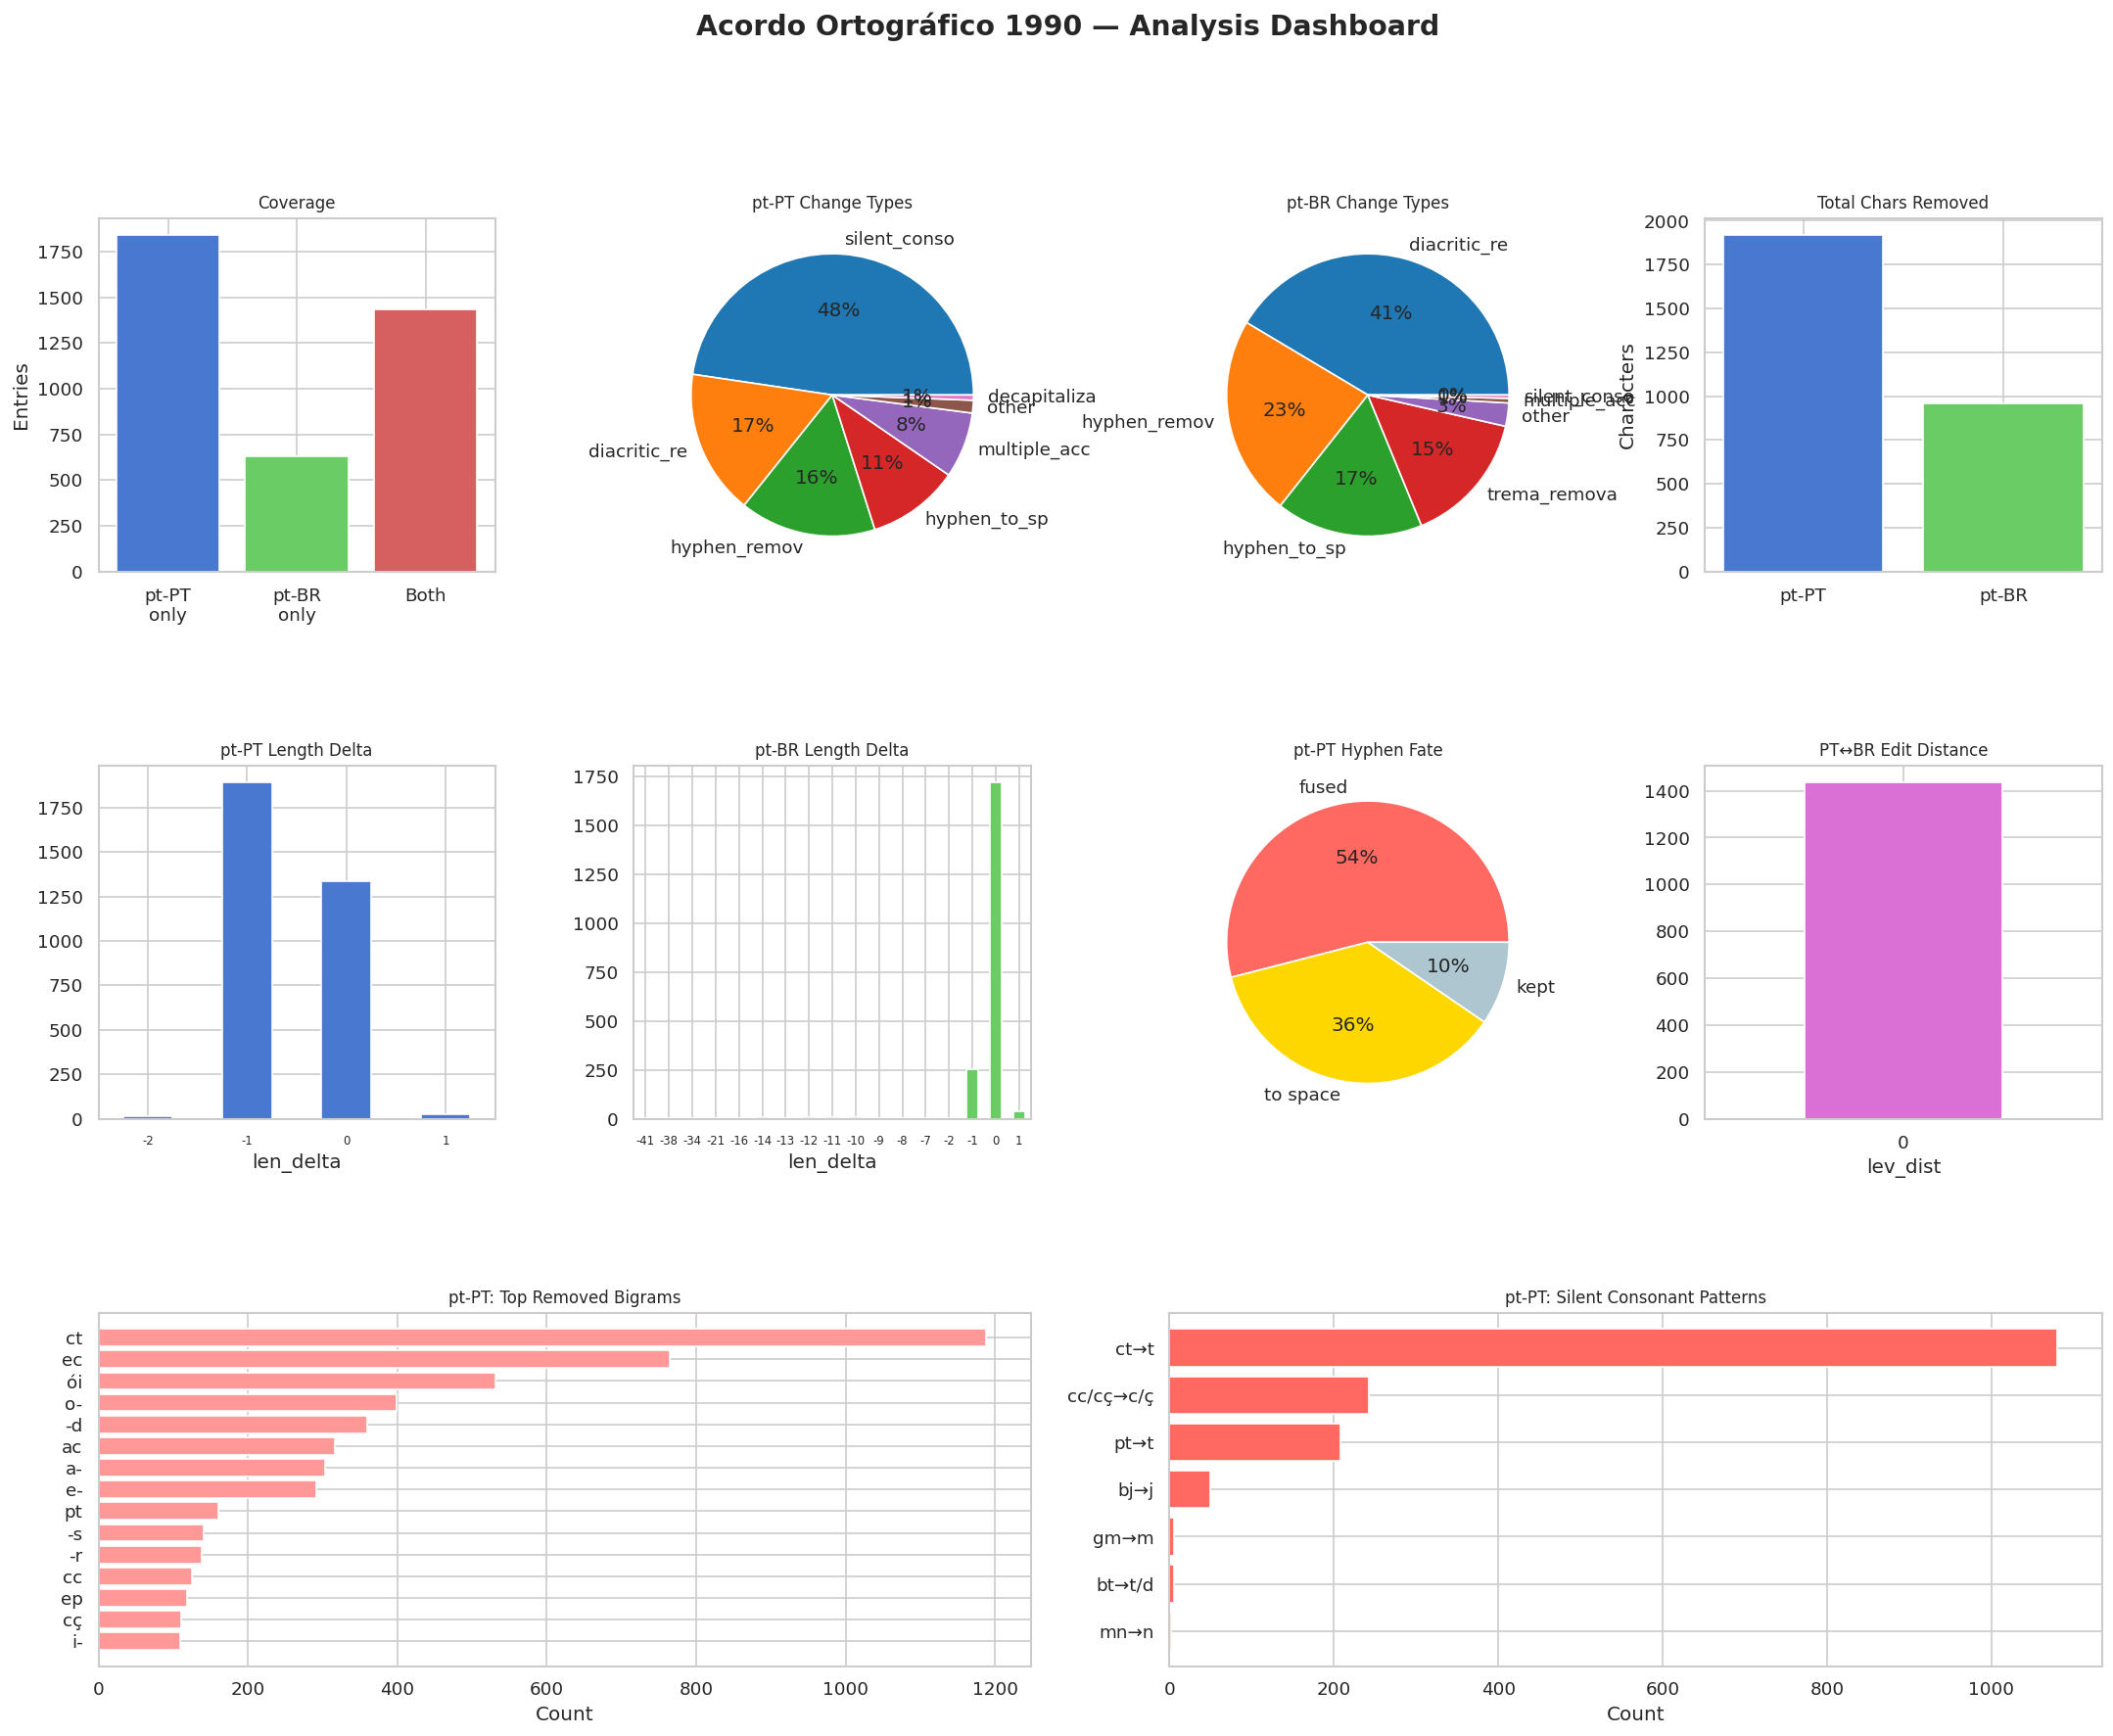

Dashboard saved: ./ao_output/00_dashboard.png


In [19]:
fig = plt.figure(figsize=(22, 16))
gs  = gridspec.GridSpec(3, 4, figure=fig, hspace=0.55, wspace=0.35)
fig.suptitle('Acordo Ortográfico 1990 — Analysis Dashboard', fontsize=17, fontweight='bold', y=0.99)

# 1. Coverage
ax = fig.add_subplot(gs[0,0])
ax.bar(['pt-PT\nonly','pt-BR\nonly','Both'],
       [origin_counts.get('pt_PT_only',0), origin_counts.get('pt_BR_only',0),
        origin_counts.get('both',0)],
       color=['#4878CF','#6ACC65','#D65F5F'], edgecolor='white')
ax.set_title('Coverage', fontsize=10); ax.set_ylabel('Entries')

# 2. PT change types
ax = fig.add_subplot(gs[0,1])
ct_pt = pt_exp['change_types'].value_counts()
ax.pie(ct_pt, labels=[k[:12] for k in ct_pt.index], autopct='%1.0f%%',
       colors=sns.color_palette('tab10', len(ct_pt)))
ax.set_title('pt-PT Change Types', fontsize=10)

# 3. BR change types
ax = fig.add_subplot(gs[0,2])
ct_br = br_exp['change_types'].value_counts()
ax.pie(ct_br, labels=[k[:12] for k in ct_br.index], autopct='%1.0f%%',
       colors=sns.color_palette('tab10', len(ct_br)))
ax.set_title('pt-BR Change Types', fontsize=10)

# 4. Chars saved
ax = fig.add_subplot(gs[0,3])
ax.bar(['pt-PT','pt-BR'],
       [-pt_m.loc[pt_m['len_delta']<0,'len_delta'].sum(),
        -br_m.loc[br_m['len_delta']<0,'len_delta'].sum()],
       color=['#4878CF','#6ACC65'], edgecolor='white')
ax.set_title('Total Chars Removed', fontsize=10); ax.set_ylabel('Characters')

# 5. Length delta distribution PT
ax = fig.add_subplot(gs[1,0])
pt_m['len_delta'].value_counts().sort_index().plot(kind='bar', ax=ax, color='#4878CF', edgecolor='white')
ax.set_title('pt-PT Length Delta', fontsize=10)
ax.tick_params(axis='x', rotation=0, labelsize=7)

# 6. Length delta distribution BR
ax = fig.add_subplot(gs[1,1])
br_m['len_delta'].value_counts().sort_index().plot(kind='bar', ax=ax, color='#6ACC65', edgecolor='white')
ax.set_title('pt-BR Length Delta', fontsize=10)
ax.tick_params(axis='x', rotation=0, labelsize=7)

# 7. Hyphen fate PT
ax = fig.add_subplot(gs[1,2])
fates2 = pt_m[pt_m['hyphen_fate']!='no_hyphen']['hyphen_fate'].value_counts()
ax.pie(fates2, labels=[f.replace('_',' ') for f in fates2.index],
       autopct='%1.0f%%', colors=[hyphen_palette.get(k,'grey') for k in fates2.index])
ax.set_title('pt-PT Hyphen Fate', fontsize=10)

# 8. Lev dist distribution
ax = fig.add_subplot(gs[1,3])
shared['lev_dist'].value_counts().sort_index().plot(kind='bar', ax=ax, color='orchid', edgecolor='white')
ax.set_title('PT↔BR Edit Distance', fontsize=10)
ax.tick_params(axis='x', rotation=0)

# 9. Top removed bigrams PT
ax = fig.add_subplot(gs[2,0:2])
top_bi = pt_bigrams_removed.most_common(15)
bi_lbl, bi_cnt = zip(*top_bi)
ax.barh(bi_lbl[::-1], bi_cnt[::-1], color='#FF9896', edgecolor='white')
ax.set_title('pt-PT: Top Removed Bigrams', fontsize=10)
ax.set_xlabel('Count')

# 10. Silent consonant patterns
ax = fig.add_subplot(gs[2,2:4])
labels_, vals_ = zip(*sorted(pattern_counts.items(), key=lambda x: -x[1]))
ax.barh(labels_[::-1], vals_[::-1], color='#FF6961', edgecolor='white')
ax.set_title('pt-PT: Silent Consonant Patterns', fontsize=10)
ax.set_xlabel('Count')

p = os.path.join(OUTPUT_DIR, '00_dashboard.png')
plt.savefig(p, bbox_inches='tight', dpi=FIG_DPI)
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)
print('Dashboard saved:', p)

## 📋 Section 12 — Summary Statistics

In [20]:
summary = {
    'pt-PT entries'                     : f"{len(pt_raw):,}",
    'pt-BR entries'                     : f"{len(br_raw):,}",
    'Unified entries'                   : f"{len(unified):,}",
    'In both lists'                     : f"{origin_counts.get('both',0):,}",
    'pt-PT exclusive'                   : f"{origin_counts.get('pt_PT_only',0):,}",
    'pt-BR exclusive'                   : f"{origin_counts.get('pt_BR_only',0):,}",
    'Divergent new forms'               : f"{unified['new_forms_differ'].sum()}",
    'Avg lev dist (shared)'             : f"{shared['lev_dist'].mean():.4f}",
    'pt-PT avg length delta'            : f"{pt_m['len_delta'].mean():.2f} chars",
    'pt-BR avg length delta'            : f"{br_m['len_delta'].mean():.2f} chars",
    'pt-PT % shortened'                 : f"{(pt_m['len_delta']<0).mean()*100:.1f}%",
    'pt-BR % shortened'                 : f"{(br_m['len_delta']<0).mean()*100:.1f}%",
    'pt-PT total chars removed'         : f"{-pt_m.loc[pt_m['len_delta']<0,'len_delta'].sum():,}",
    'pt-BR total chars removed'         : f"{-br_m.loc[br_m['len_delta']<0,'len_delta'].sum():,}",
    'pt-PT hyphenated→fused'            : f"{(pt_m['hyphen_fate']=='fused').sum():,}",
    'pt-PT hyphenated→space'            : f"{(pt_m['hyphen_fate']=='to_space').sum():,}",
    'pt-PT multiple accepted forms'     : f"{pt_raw['new_form'].str.contains(',').sum():,}",
    'pt-BR multiple accepted forms'     : f"{br_raw['new_form'].str.contains(',').sum():,}",
}

summary_df = pd.DataFrame(list(summary.items()), columns=['Metric','Value'])
print(summary_df.to_string(index=False))

p_csv = os.path.join(OUTPUT_DIR, 'summary_stats.csv')
summary_df.to_csv(p_csv, index=False)
if MLFLOW_TRACKING: mlflow.log_artifact(p_csv)

                       Metric       Value
                pt-PT entries       3,265
                pt-BR entries       2,058
              Unified entries       3,908
                In both lists       1,435
              pt-PT exclusive       1,840
              pt-BR exclusive         633
          Divergent new forms           0
        Avg lev dist (shared)      0.0000
       pt-PT avg length delta -0.58 chars
       pt-BR avg length delta -0.45 chars
            pt-PT % shortened       58.3%
            pt-BR % shortened       14.7%
    pt-PT total chars removed       1,917
    pt-BR total chars removed         956
       pt-PT hyphenated→fused         526
       pt-PT hyphenated→space         355
pt-PT multiple accepted forms         254
pt-BR multiple accepted forms          11


## 🏁 Finish

In [22]:
if MLFLOW_TRACKING:
    mlflow.end_run()
    print(f"MLflow done. UI: mlflow ui --backend-store-uri {MLFLOW_URI}")

print("\n✅ Analysis complete!")
print(f"Unified CSV   : {UNIFIED_CSV}")
print(f"All artifacts : {OUTPUT_DIR}")
import glob
for f in sorted(glob.glob(os.path.join(OUTPUT_DIR, '*'))):
    print(f"  {os.path.basename(f):45s}  {os.path.getsize(f)/1024:.1f} KB")

MLflow done. UI: mlflow ui --backend-store-uri ./mlruns

✅ Analysis complete!
Unified CSV   : ./ao_output/unified_ortho.csv
All artifacts : ./ao_output
  00_dashboard.png                               222.3 KB
  01_overview.png                                78.1 KB
  02_change_types.png                            99.5 KB
  03_pt_vs_br_changes.png                        65.3 KB
  04_word_length_changes.png                     153.2 KB
  05_hyphen_changes.png                          77.7 KB
  06_char_changes.png                            120.9 KB
  07_ngram_removed.png                           102.9 KB
  08_pt_br_divergence.png                        45.3 KB
  09_exclusive_changes.png                       76.9 KB
  10_silent_consonants.png                       32.9 KB
  summary_stats.csv                              0.5 KB
  unified_ortho.csv                              250.2 KB
